In [153]:
import numpy as np
import matplotlib.pyplot as plt

import math
import scipy.sparse as sps

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}


from fastprogress import progress_bar

import jlinops
import sampi


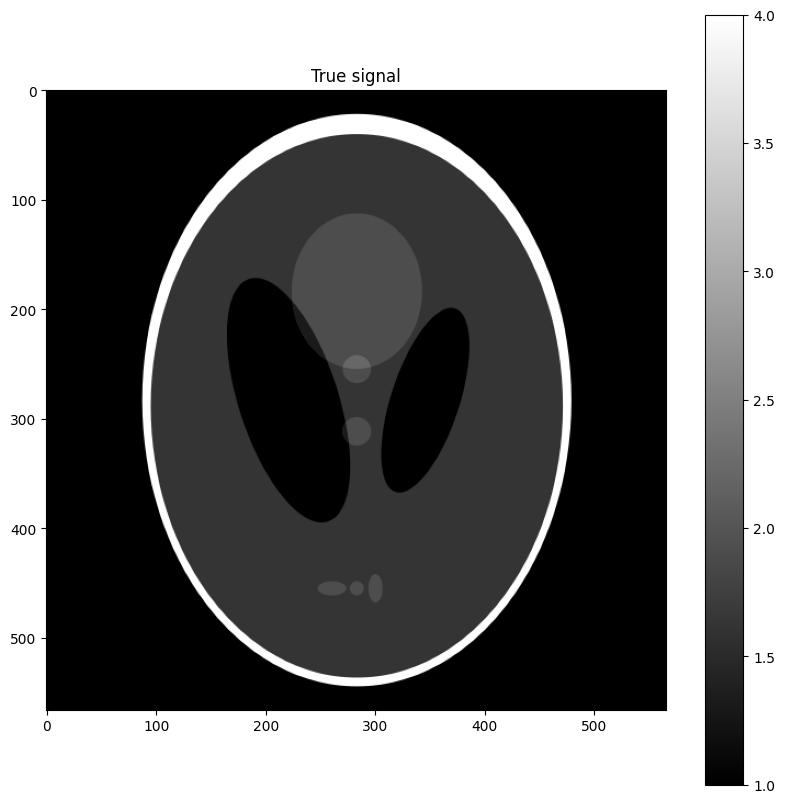

In [83]:
# Draw random image
np.random.seed(1)
image = 3*jlinops.shepplogan() + 1
img_shape = image.shape

plt.figure(figsize=(10,10))
plt.imshow(image, cmap="gray")
plt.title("True signal")
plt.colorbar()
plt.show()

/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_56841/2613335775.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


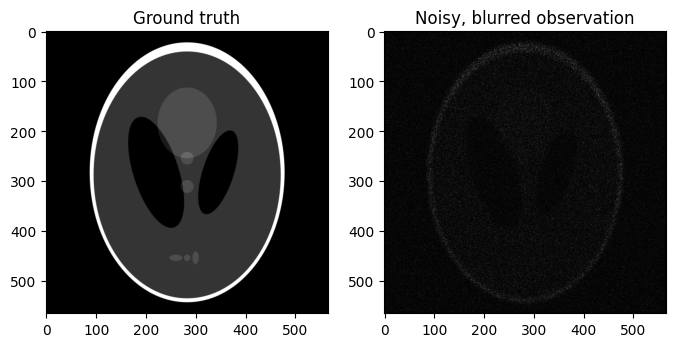

In [107]:
# Make blurring operator
blur_sigma = np.array(3.0).astype(np.float64) # standard deviation of the blur
A = jlinops.Gaussian2DBlurOperator(image.shape, blur_sigma, mode="constant")

# Multiplicative noise
L = 1
np.random.seed(0)
noisy_signal = A.matvec(image.flatten())*np.random.gamma(shape=L, scale=1/L, size=A.shape[1])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8,5))
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Ground truth")
axs[1].imshow(noisy_signal.reshape(img_shape), cmap="gray")
axs[1].set_title("Noisy, blurred observation")
fig.show()

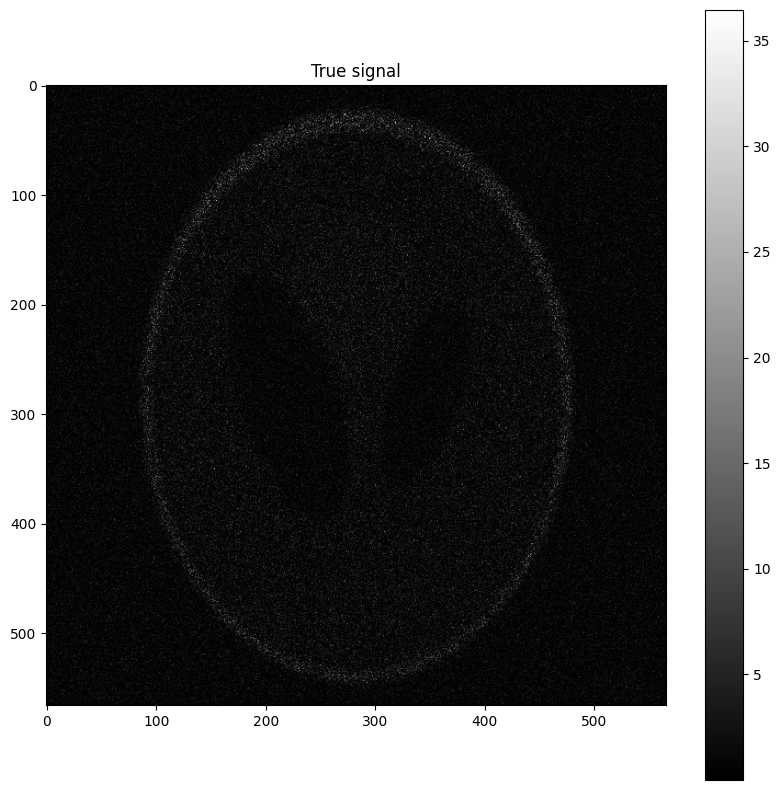

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(noisy_signal.reshape(img_shape), cmap="gray")
plt.title("True signal")
plt.colorbar()
plt.show()

# Solver

In [110]:

class DespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, A, R, f, hyperparams, L=1, pdata={}):

        # Bind
        self.f = f
        self.R = R
        self.A = A
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, u0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if u0 is None:
            u = np.ones(self.n)
        else:
            u = u0
        
        # Handle warmstarting
        if warmstarting:
            u_prev = u.copy()
        else:
            u_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        newton_flags = []
        newton_iters = []
        
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update prior thetas
            theta_curr = self.theta_update(u)

            # Update u
            u, iters, flag = self.x_update(theta_curr, u0=u_prev, priorconditioning=priorconditioning, **x_update_solver_params)
            newton_flags.append(flag)
            newton_iters.append(iters)
            if warmstarting:
                u_prev = u.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(u, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "u": u,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters,
            "newton_iters": newton_iters,
            "newton_flags": newton_flags,
        }

        return data



    def x_update(self, theta, u0, priorconditioning=False, **kwargs):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        if not priorconditioning:

            # Call projected Newton-Krylov solver
            newton_data = sampi.despeckling_newton_krylov(self.A, self.R, theta, self.L, self.f, u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]


        else:

            # Build current Rpinv operator
            if self.pdata["Rpinv_factory"] is None:
                Rpinv = None
            else:
                Rpinv = self.pdata["Rpinv_factory"](theta)

            #despeckling_priorconditioned_newton_krylov

            newton_data = sampi.despeckling_priorconditioned_newton_krylov(self.f, self.L, self.A, Rtilde, Rpinv, self.pdata["W"], u0=u0, Rinv=self.pdata["Rinv"], **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]
          

            # # Build current Rpinv operator
            # Rpinv = self.pdata["Rpinv_factory"](theta)

            # newton_data = sampi.log_despeckling_priorconditioned_newton_krylov(self.y, self.L, Rtilde, Rpinv, self.pdata["W"], x0=x0, **kwargs)

            # return newton_data["x"], newton_data["n_iters"], newton_data["converged"]



        
    def theta_update(self, u):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (u) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, u, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        Au = self.A.matvec(u)
        gamma_likelihood = self.L*(np.log( Au ).sum() + (self.f/Au).sum())
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ u)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = gamma_likelihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        



# Test

In [111]:
# W = np.ones(M*N)
# W = jlinops.MatrixLinearOperator(W)

R = jlinops.Neumann2D(img_shape)
Rpinv_factory = lambda theta: jlinops.CGWeightedNeumann2DPinvOperator(img_shape, 1.0/np.sqrt(theta), which="scipy", tol=1e-1)


# R, W = jlinops.first_order_derivative_2d(img_shape, boundary="none")
# W = jlinops.MatrixLinearOperator(W)
# R = jlinops.MatrixLinearOperator(R)
# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ R.A)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-5)
    
# R = jlinops.IdentityOperator( (M*N, M*N) )
# Rpinv_factory = lambda theta: jlinops.MatrixLinearOperator(sps.diags(np.sqrt(theta)))



# pdata = {
#     "Rinv": jlinops.IdentityOperator( (M*N, M*N) ),
#     #"Rpinv_factory": Rpinv_factory,
# }

In [128]:
# Prior parameters
# reg_lambda = 5*1e-0
# vartheta = 2/(reg_lambda**2)
# hyperparams = {
#     "prior": {
#         "r": 1.0,
#         "beta": 1.5 + 1e-5,
#         "vartheta": vartheta,
#     },
# }

hyperparams = {
    "prior": {
        "r": -1,
        "beta": 1,
        "vartheta": 1e-1,
    },
}

# Create solver
solver = DespecklingIASSolver(A, R, noisy_signal, hyperparams, L=L, pdata=pdata)

In [129]:
priorconditioning = False
x_update_solver_params = {
    "newton_maxiter": 40,
    "newton_tol": 1e-3,
    "cg_tol": 1e-3,
    "cg_maxiter": None,
    "backtrack_alpha": 0.4,
    "backtrack_beta": 0.9,
    "search_maxiter": 100,
}

# priorconditioning = True
# x_update_solver_params = {
#     "newton_maxiter": 40,
#     "newton_tol": 1e-3,
#     "tol": 1e-15,
#     "maxiter": None,
#     "backtrack_alpha": 0.4,
#     "backtrack_beta": 0.9,
#     "search_maxiter": 100,
# }

data = solver.solve(max_iters=200, u0=image.flatten(), warmstarting=True, eps=1e-4, early_stopping=True,
                    x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

9
7
6
5
4
2
2


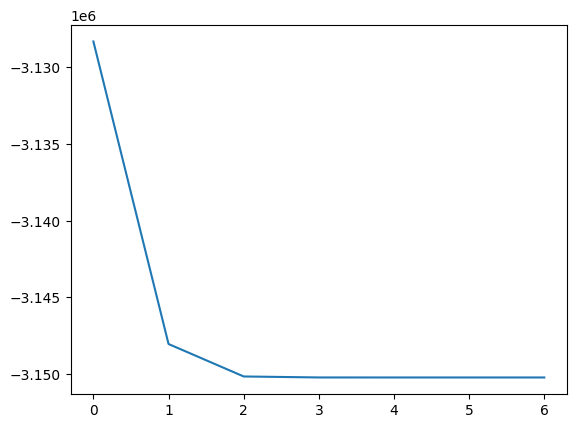

In [135]:
plt.plot(data["obj_vals"])
plt.show()

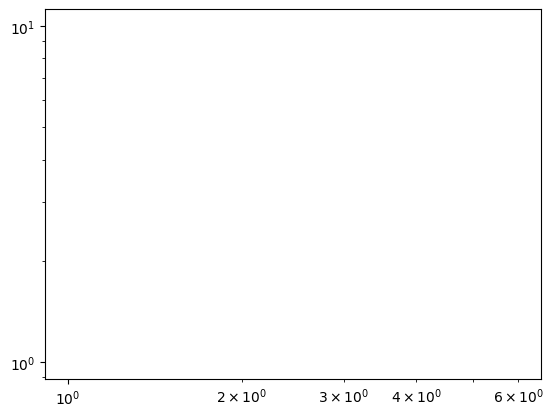

In [136]:
plt.loglog(data["obj_vals"])
plt.show()

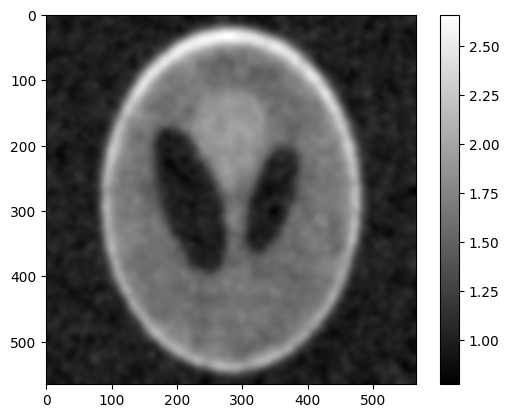

In [139]:
plt.imshow(data["u"].reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

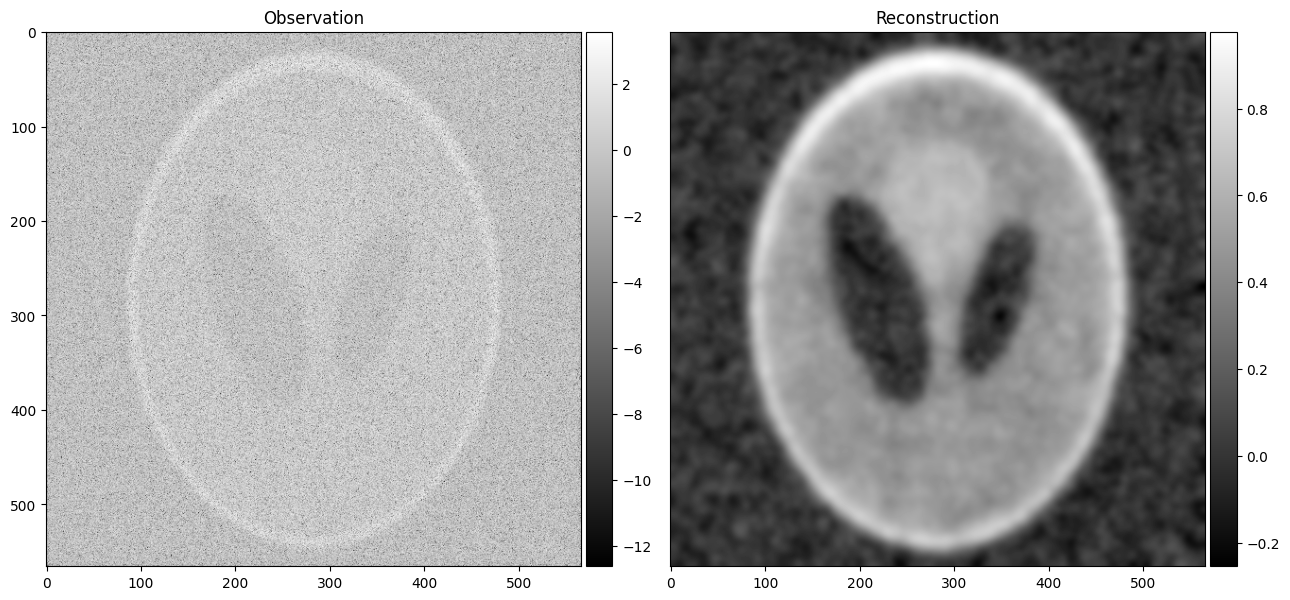

In [142]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,2,figsize=(13,8))

# Function to adjust colorbar
def add_colorbar(im, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


im1 = axs[0].imshow(  np.log(noisy_signal.reshape(img_shape)) , cmap="gray")
add_colorbar(im1, axs[0])
axs[0].set_title("Observation")


im2 = axs[1].imshow( np.log(data["u"].reshape(img_shape)) , cmap="gray")
add_colorbar(im2, axs[1])
axs[1].set_yticks([])
axs[1].set_title("Reconstruction")

fig.tight_layout()

fig.savefig("shepp_logan_example.png", dpi=400, bbox_inches='tight', pad_inches=0.1)

plt.show()

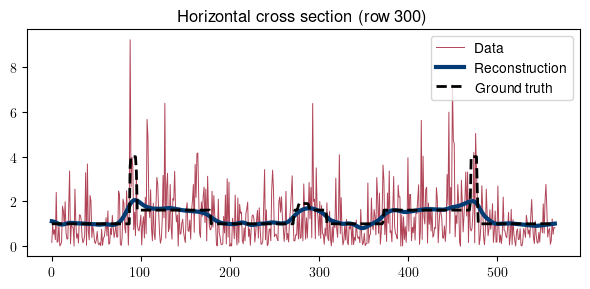

In [191]:
plt.figure(figsize=(6,3))
loc = 300
plt.plot(noisy_signal.reshape(img_shape)[loc,:], alpha=0.8, color=dcolors["bonfire_red"], label="Data", lw=0.7 )
#plt.scatter( [i for i in range(len(image[loc,:]))]  , noisy_signal.reshape(img_shape)[450,:], s=1.0, alpha=0.95, color=dcolors["bonfire_red"]  )
plt.plot( data["u"].reshape(img_shape)[loc,:] , color=dcolors["river_navy"] , lw=3.0, label="Reconstruction")
plt.plot( image[loc,:] , label="Ground truth", color=dcolors["midnight_black"], ls="--", lw=2.0)

plt.title("Horizontal cross section (row 300)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("cross_section_shepp_logan.png", dpi=250, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [143]:

dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

(566, 566)

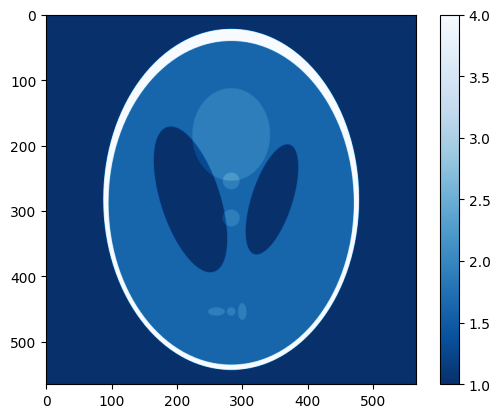

In [133]:
plt.imshow(image, cmap="Blues_r")
plt.colorbar()
plt.show()

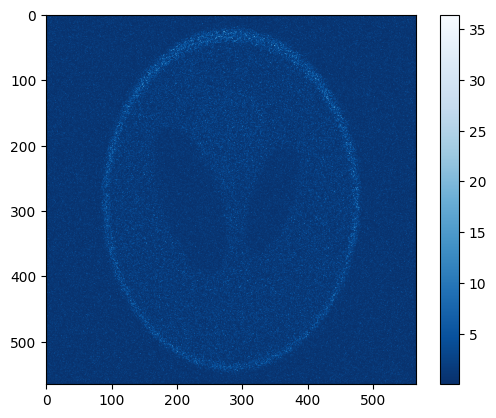

In [134]:
plt.imshow(noisy_signal.reshape(img_shape), cmap="Blues_r")
plt.colorbar()
plt.show()